<a href="https://colab.research.google.com/github/shalabh147/Brain-Tumor-Segmentation-and-Survival-Prediction-using-Deep-Neural-Networks/blob/master/surv_pred_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras import layers
from keras import callbacks
from keras import optimizers
from keras.models import Model, load_model
# from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Maximum, Flatten
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Maximum, Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv3D, Conv3DTranspose, UpSampling2D
# from tensorflow.keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose,UpSampling2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D, MaxPooling3D, AveragePooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import adam_v2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import seaborn as sns
from sklearn.metrics import confusion_matrix

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight
from keras.models import Sequential
import nibabel as nib
import csv
import os

In [2]:
path_project = '/home/origin/Research/'
path_clinical = path_project + 'Data/clinical/Pre-operative_TCGA-GBM/survival_info_all.csv'
path_MRI_training = path_project + 'Data/MRI/Pre-operative/Training/'
path_MRI_validation = path_project + 'Data/MRI/Pre-operative/Validation/'

IDs_patients = os.listdir(path_MRI_training) + os.listdir(path_MRI_validation)
IDs_patients.sort()
count_patients = len(IDs_patients)
age_dict = {}
OS_dict = {}
threshold = 360 # days
seg_label = 'GlistrBoost.nii'


def standardize(image):
  standardized_image = np.zeros(image.shape)
  # iterate over the `z` dimension
  for z in range(image.shape[2]):
    # get a slice of the image at channel c and z-th dimension `z`
    image_slice = image[:, :, z]
    # subtract the mean from image_slice
    centered = image_slice - np.mean(image_slice)
    # divide by the standard deviation (only if it is different from zero)
    if np.std(centered) != 0:
        centered = centered / np.std(centered)
    # update  the slice of standardized image with the scaled centered and scaled image
    standardized_image[:, :, z] = centered
    
  return standardized_image

In [3]:
dtypes = dict.fromkeys(pd.read_csv(path_clinical, encoding='gbk', nrows=1).columns.tolist(), str)
data_clinical = pd.read_csv(path_clinical, encoding='gbk', dtype=dtypes)

# produce the dict of age and overall survival
head_IDs, head_age, head_OS = list(dtypes.keys())[0], list(dtypes.keys())[1], list(dtypes.keys())[2]
cases_IDs = list(data_clinical[head_IDs])
cases_age = list(data_clinical[head_age].apply(pd.to_numeric, errors='coerce').fillna(0))
cases_OS = list(data_clinical[head_OS].apply(pd.to_numeric, errors='coerce').fillna(0))
age_dict = dict(zip(cases_IDs, cases_age))
OS_dict = dict(zip(cases_IDs, cases_OS))

In [4]:
# training set loading
training_set_all = os.listdir(path_MRI_training)
training_set = []
slice_loc_training = []

for IDs in training_set_all:
    if IDs in OS_dict.keys():
        training_set.append(IDs)
        
count_patients_training = len(training_set)
input_training = np.zeros((count_patients_training, 240, 240))
age_training = np.zeros((count_patients_training, 1))
ground_truth_training = np.zeros((count_patients_training, 2))
cnt = 0
for image_num in range(count_patients_training):
    x = training_set[image_num]
    folder_path = path_MRI_training + x
    modalities = os.listdir(folder_path)
    modalities.sort()

    image_data2 = np.zeros((240, 240, 155))
    w = 0
    for j in range(len(modalities)):
        image_path = folder_path + '/' + modalities[j]
        if not (image_path.find('GlistrBoost.nii') == -1):
            img = nib.load(image_path)
            image_data2 = img.get_fdata()
            image_data2 = np.asarray(image_data2)
            image_data2 = standardize(image_data2)
            
    image_data2[image_data2 == 4] = 3
    slice_nonzero = []
    width, height, queue = image_data2.shape
    for i in range(0, queue, 10):
        image_array = image_data2[:, :, i]
        slice_nonzero.append(np.count_nonzero(image_array))
    slice_nonzero_array = np.array(slice_nonzero)
    slice_loc_training.append(slice_nonzero_array.argmax() * 10)

    input_training[cnt, :, :] = image_data2[:, :, slice_loc_training[image_num]]
    age_training[cnt, 0] = float(age_dict[x])
    OS_training = int(OS_dict[x])

    if int(OS_training) < threshold:
        ground_truth_training[cnt, 0] = 1
    else:
        ground_truth_training[cnt, 1] = 1
    cnt += 1
    
print('training set: ', len(input_training))

training set:  104


In [5]:
# validation set loading
validation_set = os.listdir(path_MRI_validation)
count_patients_val = len(validation_set)
slice_loc_val = []

input_val = np.zeros((count_patients_val, 240, 240))
age_val = np.zeros((count_patients_val, 1))
ground_truth_val = np.zeros((count_patients_val, 2))
cnt = 0
for image_num in range(count_patients_val):
    x = validation_set[image_num]
    folder_path = path_MRI_validation + x
    modalities = os.listdir(folder_path)
    modalities.sort()

    image_data2 = np.zeros((240, 240, 155))
    w = 0
    for j in range(len(modalities)):
        image_path = folder_path + '/' + modalities[j]
        if not (image_path.find('GlistrBoost.nii') == -1):
            img = nib.load(image_path)
            image_data2 = img.get_fdata()
            image_data2 = np.asarray(image_data2)
            image_data2 = standardize(image_data2)

    image_data2[image_data2 == 4] = 3
    slice_nonzero = []
    width, height, queue = image_data2.shape
    for i in range(0, queue, 10):
        image_array = image_data2[:, :, i] 
        slice_nonzero.append(np.count_nonzero(image_array))
    slice_nonzero_array = np.array(slice_nonzero)
    slice_loc_val.append(slice_nonzero_array.argmax() * 10)
    
    input_val[cnt, :, :] = image_data2[:, :, slice_loc_val[image_num]]
    age_val[cnt, 0] = float(age_dict[x])
    OS_val = int(OS_dict[x])

    if int(OS_val) < threshold:
        ground_truth_val[cnt, 0] = 1
    else:
        ground_truth_val[cnt, 1] = 1
    cnt += 1
    
print('validation set: ', len(input_val))

validation set:  17


In [6]:
cnt = 0
for patients_num in range(count_patients):
  image1 = IDs_patients[patients_num]
  if image1 in OS_dict:
    cnt += 1
print('the number of patients who have age and OS information: ', cnt)

print('the slices of 3D scans in training set are: ', slice_loc_training)
print('the slices of 3D scans in validation set are: ', slice_loc_val)

the number of patients who have age and OS information:  121
the slices of 3D scans in training set are:  [50, 50, 60, 40, 70, 50, 60, 30, 40, 70, 50, 30, 40, 40, 70, 50, 60, 30, 60, 30, 60, 70, 70, 30, 40, 90, 40, 40, 80, 30, 60, 40, 90, 60, 50, 60, 30, 40, 40, 60, 40, 30, 30, 30, 70, 30, 90, 40, 30, 30, 50, 40, 40, 30, 30, 30, 30, 30, 30, 30, 50, 40, 40, 50, 60, 50, 50, 40, 60, 60, 40, 20, 30, 80, 40, 40, 80, 30, 30, 30, 50, 60, 60, 40, 60, 40, 60, 60, 40, 60, 30, 70, 80, 40, 70, 40, 50, 60, 60, 40, 50, 40, 70, 70]
the slices of 3D scans in validation set are:  [40, 40, 40, 40, 40, 30, 90, 50, 70, 70, 80, 40, 50, 50, 40, 40, 60]


In [7]:
def SurvPredNet(input_img,age_m):
    
    model = Sequential()
    
#     a1 = Conv2D(16,kernel_size = (3,3) , padding='same')(input_img)
#     a1 = Activation('relu')(a1)
#     a1 = Conv2D(16,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
#     a1 = Conv2D(24,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = Conv2D(24,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
#     a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
#     a1 = Conv2D(64,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = Conv2D(64,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = Conv2D(64,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(input_img)
    a1 = Activation('relu')(a1)
    a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
    a1 = Activation('relu')(a1)
    a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
    a1 = Activation('relu')(a1)
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Flatten()(a1)
    a1 = concatenate([a1,age_m])
    
    a1 = Dense(32,activation = 'relu')(a1)
    a1 = Dense(16,activation = 'relu')(a1)
    outputs = Dense(2,activation = 'softmax')(a1)
    
    model = Model(inputs = [input_img,age_m] , outputs = outputs)
    return model

# saveModel = path_project + 'Thesis/Experiments_Record/Figures/20220526/Round1/Model/'
# checkpoint = callbacks.ModelCheckpoint(saveModel+'weights.{epoch:02d}.h5', monitor='val_accuracy', verbose=0,
#                                 save_best_only=False,
#                                 save_weights_only=False, mode='max',
#                                 save_freq=10)

In [34]:
lr = 1e-5
decay_rate = 2e-7

input_img = Input((240,240,1))
age_m = Input(1)
model = SurvPredNet(input_img,age_m)
sgd = optimizers.gradient_descent_v2.SGD(learning_rate=lr, decay=decay_rate, momentum=0.9, nesterov=True)
# accu_metric = 'categorical_accuracy'
accu_metric = 'accuracy'
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=accu_metric)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=accu_metric)
# model.compile(loss='categorical_crossentropy',
#              optimizer=tf.keras.optimizers.SGD(learning_rate =0.0001),
#              metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 240, 240, 32  320         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 activation_18 (Activation)     (None, 240, 240, 32  0           ['conv2d_18[0][0]']              
                                )                                                           

In [35]:
epoch=80
bz=16
history = model.fit(x=[input_training, age_training], y=ground_truth_training, epochs=epoch, batch_size=bz, 
                    validation_data=[[input_val, age_val], ground_truth_val])
# history = model.fit(x=[input_training, age_training], y=ground_truth_training, epochs=50, batch_size=64, 
#                     validation_data=[[input_val, age_val], ground_truth_val], 
#                     callbacks=checkpoint)

Epoch 1/80
7/7 [==============================] - 1s 55ms/step - loss: 0.6962 - accuracy: 0.5288 - val_loss: 0.6603 - val_accuracy: 0.5294
Epoch 2/80
7/7 [==============================] - 0s 43ms/step - loss: 0.6890 - accuracy: 0.5481 - val_loss: 0.6589 - val_accuracy: 0.5294
Epoch 3/80
7/7 [==============================] - 0s 42ms/step - loss: 0.6785 - accuracy: 0.5769 - val_loss: 0.6602 - val_accuracy: 0.5294
Epoch 4/80
7/7 [==============================] - 0s 43ms/step - loss: 0.6692 - accuracy: 0.5865 - val_loss: 0.6607 - val_accuracy: 0.5294
Epoch 5/80
7/7 [==============================] - 0s 43ms/step - loss: 0.6592 - accuracy: 0.6442 - val_loss: 0.6593 - val_accuracy: 0.5294
Epoch 6/80
7/7 [==============================] - 0s 43ms/step - loss: 0.6500 - accuracy: 0.6538 - val_loss: 0.6587 - val_accuracy: 0.5294
Epoch 7/80
7/7 [==============================] - 0s 43ms/step - loss: 0.6415 - accuracy: 0.7212 - val_loss: 0.6566 - val_accuracy: 0.5294
Epoch 8/80
7/7 [===========

In [36]:
savepath = path_project + 'Thesis/Experiments_Record/my_code/seg+/seg/5/'

model.save(savepath + 'surv_pred3.h5')

import pickle
with open(savepath + 'log_history.txt', 'wb') as file_txt:
    pickle.dump(history.history, file_txt)

# with open('log.txt','rb') as file_txt:
#     history=pickle.load(file_txt)

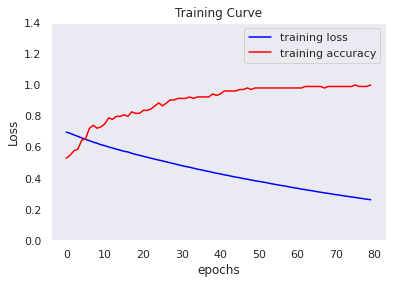

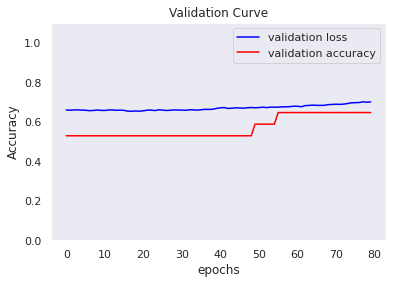

In [37]:
plt.rcParams["axes.grid"] = False
plt.plot(history.history['loss'], color='blue', label='training loss')
plt.plot(history.history[accu_metric], color='red', label='training accuracy')
plt.ylim(0, max(max(history.history['loss'])+0.4, max(history.history[accu_metric])+0.4))
plt.legend()
plt.title('Training Curve')
plt.ylabel('Loss')
plt.xlabel('epochs')
s = savepath + 'epochwise_training.pdf'
plt.savefig(s)
plt.show()
plt.close()

plt.rcParams["axes.grid"] = False
plt.plot(history.history['val_loss'], color='blue', label='validation loss')
plt.plot(history.history['val_' + accu_metric], color='red', label='validation accuracy')
plt.ylim(0,max(max(history.history['val_loss'])+0.4, max(history.history['val_' + accu_metric])+0.4))
plt.legend(bbox_to_anchor=(1,1))
plt.title('Validation Curve')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
s = savepath + 'epochwise_validation.pdf'
plt.savefig(s)
plt.show()
plt.close()

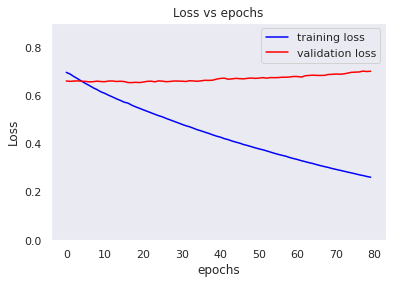

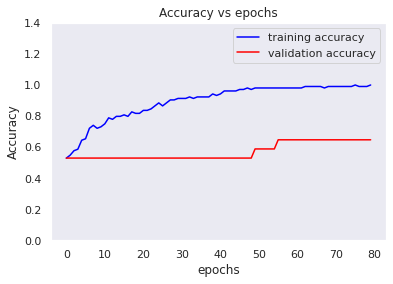

In [38]:
plt.rcParams["axes.grid"] = False
plt.plot(history.history['loss'], color='blue', label='training loss')
plt.plot(history.history['val_loss'], color='red', label='validation loss')
plt.ylim(0, max(max(history.history['loss'])+0.2, max(history.history['val_loss'])+0.2))
plt.legend()
plt.title('Loss vs epochs')
plt.ylabel('Loss')
plt.xlabel('epochs')
s = savepath + 'epochwise_loss.pdf'
plt.savefig(s)
plt.show()
plt.close()

plt.rcParams["axes.grid"] = False
plt.plot(history.history[accu_metric], color='blue', label='training accuracy')
plt.plot(history.history['val_' + accu_metric], color='red', label='validation accuracy')
plt.ylim(0,max(max(history.history[accu_metric])+0.4, max(history.history['val_' + accu_metric])+0.4))
plt.legend(bbox_to_anchor=(1,1))
plt.title('Accuracy vs epochs')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
s = savepath + 'epochwise_accuracy.pdf'
plt.savefig(s)
plt.show()
plt.close()

[[8 0]
 [6 3]]
accuracy on validation set:  0.6470588235294118


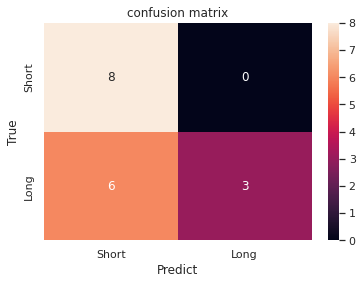

In [39]:
# confusion matrix on validation set
y_pred = model.predict(x=[input_val, age_val])
y_true = ground_truth_val
labels = ['Short', 'Long']

sns.set()
f,ax=plt.subplots()
C2= confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

print(C2)
sns.heatmap(C2,annot=True,ax=ax)
xlocations = np.array(range(len(labels)))+0.5
plt.xticks(xlocations, labels)
plt.yticks(xlocations, labels)
ax.set_title('confusion matrix')
ax.set_xlabel('Predict')
ax.set_ylabel('True')

print('accuracy on validation set: ', (C2[0][0]+C2[1][1])/(C2[0][0]+C2[1][1]+C2[0][1]+C2[1][0]))

plt.savefig(savepath + 'confusion_matrix_val.pdf')

# pd.crosstab(y_true.argmax(axis=1), y_pred.argmax(axis=1), rownames=['label'], colnames=['predict'])

True Label:  [0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1
 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1
 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0]
Prediction:  [0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1
 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1
 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[49  0]
 [ 0 55]]
accuracy is  1.0


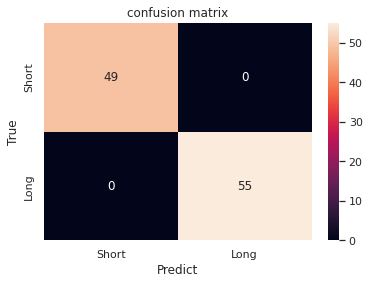

In [40]:
y_pred_training = model.predict(x=[input_training, age_training])
y_true_training = ground_truth_training
labels = ['Short', 'Long']

print('True Label: ', y_true_training.argmax(axis=1))
print('Prediction: ', y_pred_training.argmax(axis=1))
print(y_true_training.argmax(axis=1) - y_pred_training.argmax(axis=1))

sns.set()
f,ax=plt.subplots()
C2= confusion_matrix(y_true_training.argmax(axis=1), y_pred_training.argmax(axis=1))

print(C2)
sns.heatmap(C2,annot=True,ax=ax)
xlocations = np.array(range(len(labels)))+0.5
plt.xticks(xlocations, labels)
plt.yticks(xlocations, labels)
ax.set_title('confusion matrix')
ax.set_xlabel('Predict')
ax.set_ylabel('True')

plt.savefig(savepath + 'confusion_matrix_training.pdf')

print('accuracy is ', (C2[0][0]+C2[1][1])/(C2[0][0]+C2[0][1]+C2[1][0]+C2[1][1]))

In [41]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score

# # prediction on training set
# y_predict = model.predict([input_training, age], verbose=1)
# # y_predict = (y_predict > 0.007).astype(int)
# y_predict = (y_predict > 0.01).astype(int)
# y_true = np.reshape(ground_truth, [-1])
# y_pred = np.reshape(y_predict, [-1])
y_pred = model.predict([input_training, age_training], verbose=1)
y_pred = y_pred.argmax(axis=1)
y_true = ground_truth_training
y_true = y_true.argmax(axis=1)

# evalution index
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')

# Micro F1: 将n分类的评价拆成n个二分类的评价，将n个二分类评价的TP、FP、RN对应相加，计算评价准确率和召回率，由这2个准确率和召回率计算的F1 score即为Micro F1。
# Macro F1: 将n分类的评价拆成n个二分类的评价，计算每个二分类的F1 score，n个F1 score的平均值即为Macro F1。
# 一般来讲，Macro F1、Micro F1高的分类效果好。Macro F1受样本数量少的类别影响大。
micro_f1 = f1_score(y_true, y_pred,average='micro')
macro_f1 = f1_score(y_true, y_pred,average='macro')

print('accuracy:',accuracy)
print('precision:',precision)
print('recall:',recall)
print('f1score:',f1score)
print('Macro-F1: {}'.format(macro_f1))
print('Micro-F1: {}'.format(micro_f1))

# prediction on validation set
print('\n\n')
# y_predict_val = model.predict([input_to_val, age_val], verbose=1)
# y_predict_val = (y_predict_val > 0.01).astype(int)
# y_true_val = np.reshape(ground_truth_val, [-1])
# y_pred_val = np.reshape(y_predict_val, [-1])
y_pred_val = model.predict([input_val, age_val], verbose=1)
y_pred_val = y_pred_val.argmax(axis=1)
y_true_val = ground_truth_val
y_true_val = y_true_val.argmax(axis=1)

# evalution index
accuracy_val = accuracy_score(y_true_val, y_pred_val)
precision_val = precision_score(y_true_val, y_pred_val)
recall_val = recall_score(y_true_val, y_pred_val, average='binary')
f1score_val = f1_score(y_true_val, y_pred_val, average='binary')

# Micro F1: 将n分类的评价拆成n个二分类的评价，将n个二分类评价的TP、FP、RN对应相加，计算评价准确率和召回率，由这2个准确率和召回率计算的F1 score即为Micro F1。
# Macro F1: 将n分类的评价拆成n个二分类的评价，计算每个二分类的F1 score，n个F1 score的平均值即为Macro F1。
# 一般来讲，Macro F1、Micro F1高的分类效果好。Macro F1受样本数量少的类别影响大。
micro_f1_val = f1_score(y_true_val, y_pred_val,average='micro')
macro_f1_val = f1_score(y_true_val, y_pred_val,average='macro')

print('accuracy_val:',accuracy_val)
print('precision_val:',precision_val)
print('recall_val:',recall_val)
print('f1score_val:',f1score_val)
print('Macro-F1_val: {}'.format(macro_f1_val))
print('Micro-F1_val: {}'.format(micro_f1_val))

4/4 [==============================] - 0s 25ms/step
accuracy: 1.0
precision: 1.0
recall: 1.0
f1score: 1.0
Macro-F1: 1.0
Micro-F1: 1.0



1/1 [==============================] - 0s 11ms/step
accuracy_val: 0.6470588235294118
precision_val: 1.0
recall_val: 0.3333333333333333
f1score_val: 0.5
Macro-F1_val: 0.6136363636363636
Micro-F1_val: 0.6470588235294118


In [42]:
############################### save the hyperparameters and metrics ###############################
import tensorflow.keras.backend as K
trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

with open(savepath + 'log.txt','w',encoding='utf-8') as f:
    f.write('optimizer: ' + 'sgd' + '\n')
    f.write('learning rate: ' + str(lr) + '\n')
    f.write('decay rate: ' + str(decay_rate) + '\n')
    f.write('epochs: ' + str(epoch) + '\n')
    f.write('batch size: ' + str(bz) + '\n')
    f.write('total parameters: ' + str(int(trainable_count + non_trainable_count)))
    
    f.write('\n\n######################################\n\n')
    f.write('accuracy: ' + str(accuracy_val) + '\n')
    f.write('precision: ' + str(precision_val) + '\n')
    f.write('recall: ' + str(recall_val) + '\n')
    f.write('f1score: ' + str(f1score_val) + '\n')
    
    f.write('\n\n######################################\n\n')
    model.summary(print_fn=lambda x: f.write(x + '\n'))